In [1]:
!nvidia-smi

Fri Nov 21 19:58:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:31:00.0 Off |                    0 |
| N/A   41C    P0             18W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Set-up

In this example, we allow running inference either on a single GPU or multiple GPUs.

In [2]:
from utils import bbox_iou, mask_iou, sample_points_from_mask, mask_to_bbox

In [3]:
import os
import sam3
import torch

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# use all available GPUs on the machine
#gpus_to_use = range(torch.cuda.device_count())
# # use only a single GPU
gpus_to_use = [torch.cuda.current_device()]

/home/reite/Reite/testspace/sam3/venv/lib/python3.12/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(gpus_to_use=gpus_to_use)

INFO 2025-11-21 19:58:14,505 256270 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-21 19:58:14,616 256270 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-21 19:58:14,617 256270 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-21 19:58:20,862 256270 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-21 19:58:23,501 256270 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-21 19:58:23,502 256270 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




#### Inference and visualization utils

In [5]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
    save_masklet_video
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

### Loading an example video

We assume that the video is stored as either **a list of JPEG frames with filenames like `<frame_index>.jpg`** or **an MP4 video**.

Note that you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [8]:
# "video_path" needs to be either a JPEG folder or a MP4 video file
video_path = "/data/engine_reite_results/jreOUu1p6MjTlf18ZOwF/ext_top/frames" # f"{sam3_root}/assets/videos/0001"

In [9]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

### Opening an inference session on this video

SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference session** on this video.

During initialization, it loads all the video frames and stores their pixels in the session state.

In [10]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (image folder) [rank=0]: 100%|██████████| 480/480 [00:05<00:00, 82.90it/s]


### Video promptable concept segmentation with text

Using SAM 3 you can describe objects using natural language, and the model will automatically detect and track all instances of that object throughout the video.

In the example below, we add a text prompt on frame 0 and propagation throughout the video. Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [11]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

In [13]:
import tqdm 
import time 
prompt_text_list = ["right hand", "left hand", "cellphone", "small object"]
global_outs = {}
start = time.time()
for frame_idx in tqdm.tqdm(range(len(video_frames_for_vis))):
    _ = predictor.handle_request(
            request=dict(
                type="reset_session",
                session_id=session_id,
            )
        )
    outs = None
    for prompt_text_str in prompt_text_list:

        _ = predictor.handle_request(
            request=dict(
                type="reset_session",
                session_id=session_id,
            )
        )
        
        response = predictor.handle_request(
            request=dict(
                type="add_prompt",
                session_id=session_id,
                frame_index=frame_idx,
                text=prompt_text_str
            )
        )
        out = response["outputs"]
        init_keep_ids = [id for id in np.arange(out["out_obj_ids"].shape[0]) if out["out_probs"][id]>0.6]
        
        if prompt_text_str == "small object" and len(init_keep_ids)==0:
            print("No small object found, discarding this frame")
            break
        
        out["out_obj_ids"] = np.arange(len(init_keep_ids))
        for key in out:
            if isinstance(out[key], np.ndarray) and key!="out_obj_ids":
                out[key] = out[key][init_keep_ids]
            elif isinstance(out[key], dict):
                k = "num_obj_tracked"
                out[key][k] = len(init_keep_ids)
            
        if outs is None:
            outs = out
            outs["labels"] = [prompt_text_str]*len(outs["out_obj_ids"])
        else:
            new_ids_to_delete = []
            old_ids_to_delete = []
            object_ids_to_keep = []
            if prompt_text_str == "small object":
                for ndx, object_mask in enumerate(out["out_binary_masks"]):
                    for odx, old_mask in enumerate(outs["out_binary_masks"]):
                        if outs["labels"][odx] == "cellphone":
                            iou = mask_iou(object_mask, old_mask)
                            if iou > 0.5:
                                new_ids_to_delete.append(ndx)
                                old_ids_to_delete.append(odx)
                        elif outs["labels"][odx] == "right hand" or outs["labels"][odx] == "left_hand":
                            object_bbox = mask_to_bbox(object_mask)
                            hand_bbox = mask_to_bbox(old_mask)
                            hand_small_object_iou = bbox_iou(object_bbox, hand_bbox)
                            if hand_small_object_iou > 0.1 and out["out_obj_ids"][ndx] not in object_ids_to_keep:
                                object_ids_to_keep.append(out["out_obj_ids"][ndx]) 
            new_ids_to_keep = [id for id in object_ids_to_keep if id not in new_ids_to_delete]
            new_ids_to_delete = [id for id in np.arange(out["out_binary_masks"].shape[0]) if id not in new_ids_to_keep]
            old_ids_to_keep = [id for id in np.arange(outs["out_binary_masks"].shape[0]) if id not in old_ids_to_delete]
            
            for key in outs.keys():
                if key == "out_obj_ids":
                    current_instances = len(outs[key][old_ids_to_keep])
                    new_instances = len(out[key][new_ids_to_keep])
                    joined_instances = current_instances + new_instances
                    outs[key] = np.arange(joined_instances)
                elif key == "labels":
                    outs[key] = np.array(outs[key])[old_ids_to_keep].tolist() + [prompt_text_str]*len(out["out_obj_ids"][new_ids_to_keep])
                elif isinstance(outs[key], np.ndarray):
                    new_key_item = np.concatenate([outs[key][old_ids_to_keep], out[key][new_ids_to_keep]], axis=0)
                    outs[key] = new_key_item
                elif isinstance(outs[key], dict):
                    k = "num_obj_tracked"
                    outs[key][k] = len(old_ids_to_keep) + len(new_ids_to_keep)
    if "right hand" not in outs["labels"] and "left hand" not in outs["labels"]:
        print("No hands detected, discarding this frame")
    else:
        global_outs[frame_idx] = outs
print(f"Global processing time: ", np.round(time.time()-start, 2), "s")

  2%|▎         | 12/480 [00:22<14:10,  1.82s/it]

No small object found, discarding this frame


  3%|▎         | 15/480 [00:27<14:07,  1.82s/it]

No small object found, discarding this frame


  4%|▎         | 17/480 [00:31<14:01,  1.82s/it]

No small object found, discarding this frame


  7%|▋         | 34/480 [01:04<14:02,  1.89s/it]


KeyboardInterrupt: 

In [11]:
outs

{'out_obj_ids': array([0, 1]),
 'out_probs': array([0.84761906, 0.7852349 ], dtype=float32),
 'out_boxes_xywh': array([[0.3234375 , 0.7270834 , 0.34843752, 0.27083334],
        [0.40312502, 0.8833334 , 0.13906251, 0.11458334]], dtype=float32),
 'out_binary_masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],
       

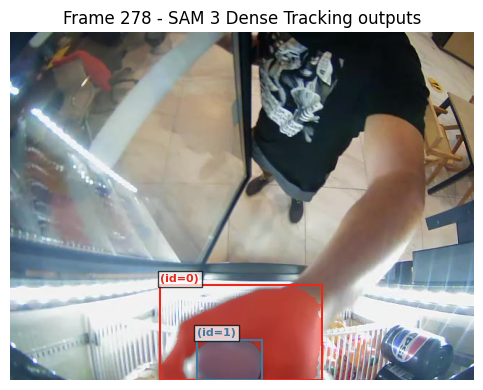

In [12]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: outs})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [13]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

In [14]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

INFO 2025-11-21 19:52:27,518 254908 sam3_video_predictor.py: 250: removed session fb448e6c-8d31-499a-adb4-91788674164f; live sessions: [], GPU memory: 5106 MiB used and 8980 MiB reserved (max over time: 8603 MiB used and 8980 MiB reserved)


In [15]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()